# Supplemental Statistics and Visualizations

This notebook provides all calculations, statistics, and visualizations used to support the final publication results.

**Note:**

Raw position data files are not available to the user.
Instead, all necessary pre-processed datasets and final outputs have been provided with the supplemental material.


## 1. Data Import and Preprocessing

In [38]:
import os
import ast

import numpy as np
import pandas as pd
import jdata as jd
import seaborn as sns
import warnings

import matplotlib.pyplot as plt

plt.style.use("ggplot")
warnings.filterwarnings("ignore")


## 1. Load Data and Preprocess


In [39]:
base_path = "./data/"
intensity_metrics = pd.read_csv(f"{base_path}results/intensity_metrics.csv")

In [40]:
# Create a unique ID per player per match
intensity_metrics["id"] = intensity_metrics["pID"] + intensity_metrics["match"]
# rescale visibility to percent
intensity_metrics["visible_percent"] = intensity_metrics["visible"] * 100

## 2. Descriptive Statistics

We summarize player distributions by role and other basic properties.

In [41]:
# Count number of players per role
# Divided by 2 because each player is listed twice (once per data source)
intensity_metrics["role"].value_counts()/2

role
DEF    28.0
MID    17.0
OFF    14.0
GK      8.0
Name: count, dtype: float64

In [42]:
# load raw data of player visibility
vis_all = {"SF": {}, "TV": {}}
for file in os.listdir(f"{base_path}player_visibility/"):
    source, match = file.split("_")[0], file.split("_")[1]
    visible = jd.load(f"{base_path}player_visibility/{source}_{match}_visible_with_ballstatus.json")
    vis_all[source].update({match: visible})
    for half in vis_all[source][match]:
        for team in vis_all[source][match][half]:
            vis_all[source][match][half][team] = vis_all[source][match][half][team][:45*60*25]

matches = ["DFL-MAT-0002UK", "DFL-MAT-0002YP", "DFL-MAT-000303", "DFL-MAT-000322"]

# frame-by-frame player visibility of all matches and both teams. 1 corresponds to visible, 0 corresponds to non-visible, NaN corresponds to player not on the pitch.
vis_sf_frames = []
vis_tv_frames = []
ballstatus_frames = []
for match in matches:
    for half in ["firstHalf", "secondHalf"]:
        for team in ["Home", "Away"]:
            vis_sf_frames.append(vis_all["SF"][match][half][team])
            vis_tv_frames.append(vis_all["TV"][match][half][team])
            ballstatus_frames.append(vis_all["TV"][match][half]["ballstatus"])


# visibilities for SF
vis_sf = np.concatenate(vis_sf_frames, axis=0)
# visibilities for TV
vis_tv = np.concatenate(vis_tv_frames, axis=0)
# ballstatus of all matches. 1 corresponds to active, 0 corresponds to inactive
ballstatus_all = np.concatenate(ballstatus_frames, axis=0)


## 3. Visibility Analysis and Figure 3

In [43]:
intensity_metrics.groupby(["role", "source"])["visible_percent"].mean()

role  source
DEF   SF        97.215635
      TV        37.264815
GK    SF        34.883056
      TV        14.059722
MID   SF        98.515076
      TV        47.837865
OFF   SF        97.631534
      TV        42.054497
Name: visible_percent, dtype: float64

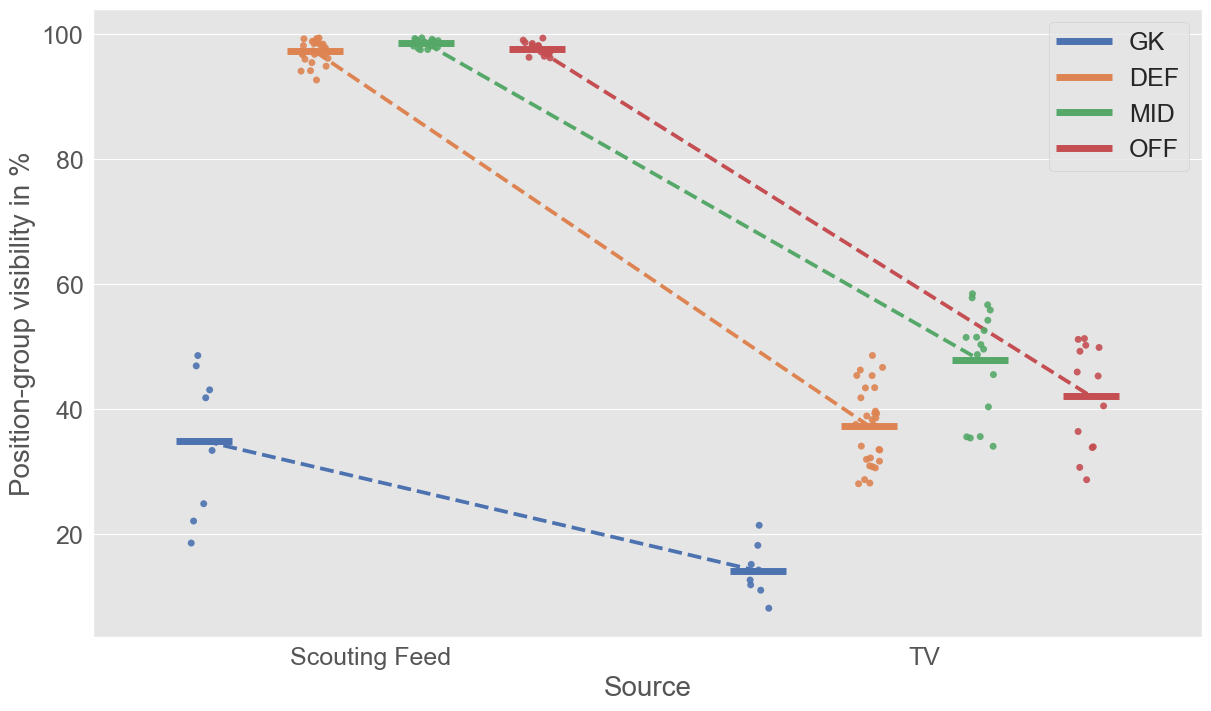

In [44]:
hue_order = ["GK", "DEF", "MID", "OFF"]
fig, ax = plt.subplots(constrained_layout=True)
palette="deep"
sns.stripplot(data=intensity_metrics, x="source", y="visible_percent", hue="role", hue_order=hue_order , dodge=True, alpha=0.9, legend=False, ax=ax, palette=palette)
sns.pointplot(data=intensity_metrics, x="source", y="visible_percent", hue="role", hue_order=hue_order, linestyle="dashed", errorbar=None, marker="_", markersize=40, markeredgewidth=5, dodge=.6, ax=ax, palette=palette)
ax.set_xticklabels(("Scouting Feed", "TV"), fontsize=18)
ax.set_xlabel("Source", fontsize=20)

plt.yticks(fontsize=18)
ax.set_ylabel("Position-group visibility in %", fontsize=20)

ax.legend(fontsize=18)
fig.set_size_inches(12,7)

# fig.savefig("fig 3.png", dpi=600)

In [45]:
#number of visible players per frame in SF
no_vis_sf = np.nansum(vis_sf, axis=1)
# number of visible players per frame in TV
no_vis_tv = np.nansum(vis_tv, axis=1)
# player visibility split by active and inactive ball status
vis_active_sf = np.nansum(vis_sf[ballstatus_all == 1], axis=1)
vis_inactive_sf = np.nansum(vis_sf[ballstatus_all == 0], axis=1)
vis_active_tv = np.nansum(vis_tv[ballstatus_all == 1], axis=1)
vis_inactive_tv = np.nansum(vis_tv[ballstatus_all == 0], axis=1)

In [46]:
df = pd.DataFrame({"SF": no_vis_sf, "TV": no_vis_tv})

In [47]:
df["SF"].value_counts() / len(df)

SF
10.0    0.582775
11.0    0.321643
9.0     0.068153
8.0     0.010270
7.0     0.003548
0.0     0.003369
6.0     0.002615
5.0     0.002469
4.0     0.001547
1.0     0.001355
3.0     0.001256
2.0     0.001001
Name: count, dtype: float64

In [48]:
df["TV"].value_counts() / len(df)

TV
0.0     0.387417
7.0     0.093676
8.0     0.087794
10.0    0.083452
6.0     0.082281
9.0     0.078666
5.0     0.057057
4.0     0.039902
11.0    0.035906
3.0     0.025187
2.0     0.015643
1.0     0.013019
Name: count, dtype: float64

In [49]:
activity_df = pd.concat(
    [pd.DataFrame({"source": "SF", "active": 1, "values": vis_active_sf}),
     pd.DataFrame({"source": "SF", "active": 0, "values": vis_inactive_sf}),
     pd.DataFrame({"source": "TV", "active": 1, "values": vis_active_tv}),
     pd.DataFrame({"source": "TV", "active": 0, "values": vis_inactive_tv})]
)

In [50]:
activity_df.loc[activity_df["source"] == "TV"]["values"].value_counts() / len(activity_df.loc[activity_df["source"] == "TV"])


values
0.0     0.387417
7.0     0.093676
8.0     0.087794
10.0    0.083452
6.0     0.082281
9.0     0.078666
5.0     0.057057
4.0     0.039902
11.0    0.035906
3.0     0.025187
2.0     0.015643
1.0     0.013019
Name: count, dtype: float64

In [51]:
activity_df.loc[activity_df["source"] == "TV"]["active"].value_counts() / len(activity_df.loc[activity_df["source"] == "TV"])

active
1    0.559885
0    0.440115
Name: count, dtype: float64

In [52]:
activity_df.loc[activity_df["source"] == "TV"].groupby("active")["values"].value_counts() / len(activity_df.loc[activity_df["source"] == "TV"])

active  values
0       0.0       0.308868
        10.0      0.021846
        7.0       0.017796
        8.0       0.016977
        9.0       0.016761
        11.0      0.014941
        6.0       0.014528
        5.0       0.010027
        4.0       0.007129
        3.0       0.005228
        2.0       0.003372
        1.0       0.002643
1       0.0       0.078549
        7.0       0.075880
        8.0       0.070818
        6.0       0.067754
        9.0       0.061905
        10.0      0.061606
        5.0       0.047031
        4.0       0.032773
        11.0      0.020965
        3.0       0.019959
        2.0       0.012270
        1.0       0.010377
Name: count, dtype: float64

### Figure 2

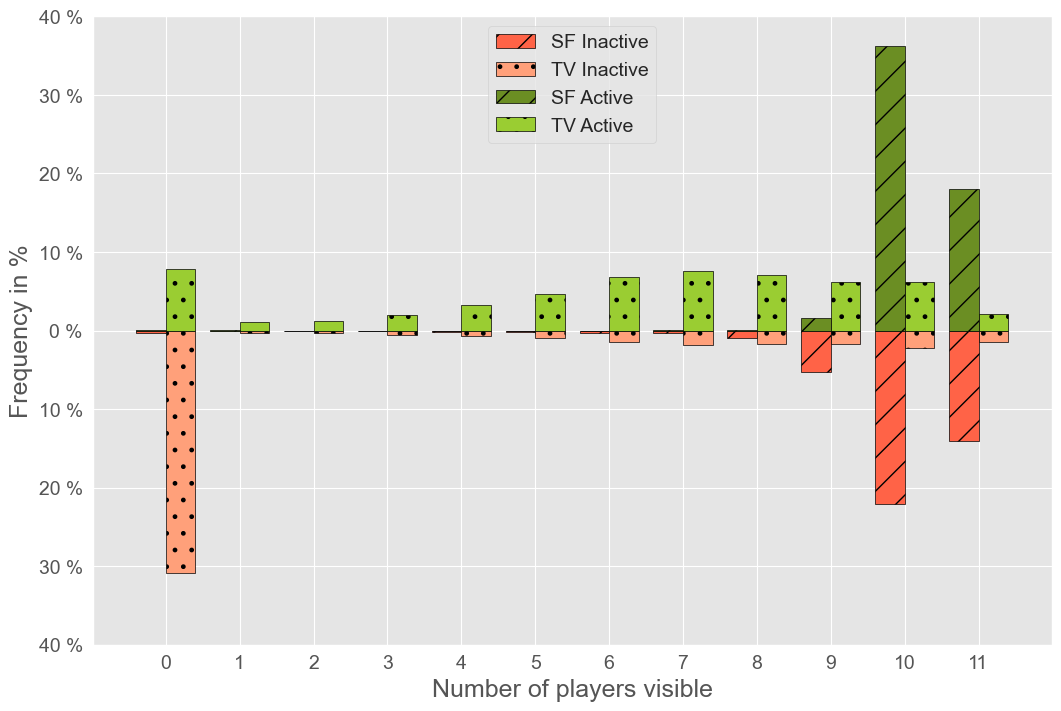

In [53]:
width = 0.4
bins = np.arange(13) - 0.5
weights_sf = [np.ones(len(vis_active_sf)) / len(no_vis_sf), np.ones(len(vis_active_tv)) / len(no_vis_tv)]
weights_tv = [np.ones(len(vis_inactive_sf)) / len(no_vis_sf), np.ones(len(vis_inactive_tv)) / len(no_vis_tv)]
hatches = ["/", "."]

fig, ax = plt.subplots(constrained_layout=True)
n1, bins1, patches1 = ax.hist([vis_inactive_sf, vis_inactive_tv], stacked=False, bins=bins, weights=weights_tv, width=width, align="mid", label=["SF Inactive", "TV Inactive"], color=["tomato", "lightsalmon"], hatch=hatches, edgecolor="black")
for p in ax.patches:
    p.set_height(-p.get_height())
n2, bins2, patches2 = ax.hist([vis_active_sf, vis_active_tv], stacked=False, bins=bins, weights=weights_sf, width=width, align="mid", label=["SF Active", "TV Active"], color=["olivedrab", "yellowgreen"], hatch=hatches, edgecolor="black")

for data_patches, hatch in zip(patches1, hatches):
    for patch in data_patches:
        patch.set_hatch(hatch)

for data_patches, hatch in zip(patches2, hatches):
    for patch in data_patches:
        patch.set_hatch(hatch)

ax.set_ylim([-0.4, 0.4])
ax.set_yticklabels(abs(ax.get_yticks()))

ax.set_yticklabels([f"{round(abs(t * 100))} %" for t in ax.get_yticks()])
 
plt.xticks(range(12))
ax.set_xlabel("Number of players visible", fontsize=18)
ax.set_ylabel("Frequency in %", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=14, loc="upper center")
fig.set_size_inches(10.5, 7)

# fig.savefig("fig 2.png", dpi=600)


### Experiment 1

In [54]:
np.round(intensity_metrics.groupby(["source", "role"])[["distance_percent", "high_speed_percent", "visible"]].mean(), 2)

distance_percent  high_speed_percent  visible
source role                                               
SF     DEF               0.98                0.94     0.97
       GK                0.37                0.71     0.35
       MID               0.99                0.92     0.99
       OFF               0.98                0.93     0.98
TV     DEF               0.44                0.49     0.37
       GK                0.17                0.31     0.14
       MID               0.55                0.48     0.48
       OFF               0.49                0.52     0.42

In [55]:
np.round(intensity_metrics.groupby(["source", "role"])[["high_speed", "high_speed_visible", "high_speed_percent"]].std(), 2)

high_speed  high_speed_visible  high_speed_percent
source role                                                    
SF     DEF       134.34              128.64                0.05
       GK         26.60               20.13                0.34
       MID       139.70              136.59                0.06
       OFF       164.74              139.61                0.04
TV     DEF       134.34               97.04                0.19
       GK         26.60               11.28                0.37
       MID       139.70               93.44                0.15
       OFF       164.74               97.11                0.20

In [56]:
np.round(intensity_metrics.groupby(["source", "role"])[["distance", "distance_visible"]].mean()/1000, 2)

distance  distance_visible
source role                            
SF     DEF      10.10              9.91
       GK        4.95              1.85
       MID      11.06             10.95
       OFF      10.62             10.44
TV     DEF      10.10              4.46
       GK        4.95              0.87
       MID      11.06              6.14
       OFF      10.62              5.25

In [57]:
np.round(intensity_metrics.groupby(["source", "role"])[["distance", "distance_visible"]].std()/1000, 2)

distance  distance_visible
source role                            
SF     DEF       0.63              0.60
       GK        0.51              0.52
       MID       0.78              0.81
       OFF       0.77              0.80
TV     DEF       0.63              0.88
       GK        0.51              0.21
       MID       0.78              1.37
       OFF       0.77              1.34

In [58]:
intensity_metrics["distance_active"] = intensity_metrics["distance"] * intensity_metrics["match_active"]
intensity_metrics["distance_inactive"] = intensity_metrics["distance"] - intensity_metrics["distance_active"]
intensity_metrics["high_speed_distance_active"] = intensity_metrics["high_speed"] * intensity_metrics["match_active"]
intensity_metrics["high_speed_distance_inactive"] = intensity_metrics["high_speed"] - intensity_metrics["high_speed_distance_active"]

In [59]:
np.round(intensity_metrics.groupby("role")[["distance_active", "distance_inactive"]].mean()/1000, 2)

,distance_active,distance_inactive
role,,
DEF,5.67,4.43
GK,2.77,2.19
MID,6.24,4.82
OFF,5.92,4.70


In [60]:
np.round(intensity_metrics.groupby("role")[["distance_active", "distance_inactive"]].std()/1000, 2)

,distance_active,distance_inactive
role,,
DEF,0.84,0.61
GK,0.41,0.44
MID,1.00,0.54
OFF,1.05,0.51


In [61]:
np.round(intensity_metrics.groupby("role")[["high_speed_distance_active", "high_speed_distance_inactive"]].mean(), 2)

,high_speed_distance_active,high_speed_distance_inactive
role,,
DEF,210.04,172.29
GK,17.70,14.16
MID,202.81,166.07
OFF,279.26,233.61


In [62]:
np.round(intensity_metrics.groupby("role")[["high_speed_distance_active", "high_speed_distance_inactive"]].std(), 2)

,high_speed_distance_active,high_speed_distance_inactive
role,,
DEF,69.02,75.49
GK,15.27,11.11
MID,70.49,77.09
OFF,85.13,94.46


In [63]:
intensity_metrics["distance_visible_active"] = intensity_metrics["distance"] * intensity_metrics["active_visible"]
intensity_metrics["distance_visible_inactive"] = intensity_metrics["distance"] * intensity_metrics["inactive_visible"]
intensity_metrics["distance_extrapolated"] = intensity_metrics["distance_visible"] * 1/intensity_metrics["visible"]

In [64]:
np.round(intensity_metrics.groupby(["source", "role"])[["distance_visible_active", "distance_visible_inactive", "distance_extrapolated"]].mean()/1000, 2)

distance_visible_active  distance_visible_inactive  \
source role                                                       
SF     DEF                      5.63                       4.18   
       GK                       0.92                       0.81   
       MID                      6.22                       4.68   
       OFF                      5.87                       4.49   
TV     DEF                      2.92                       0.86   
       GK                       0.51                       0.19   
       MID                      4.16                       1.17   
       OFF                      3.49                       1.03   

             distance_extrapolated  
source role                         
SF     DEF                   10.20  
       GK                     5.42  
       MID                   11.11  
       OFF                   10.69  
TV     DEF                   11.93  
       GK                     6.27  
       MID                   12.72  
       OFF                   12.34

In [65]:
np.round(intensity_metrics.groupby(["source", "role"])[["distance_visible_active", "distance_visible_inactive", "distance_extrapolated"]].std()/1000, 2)

distance_visible_active  distance_visible_inactive  \
source role                                                       
SF     DEF                      0.83                       0.56   
       GK                       0.33                       0.37   
       MID                      1.02                       0.52   
       OFF                      1.06                       0.47   
TV     DEF                      0.71                       0.19   
       GK                       0.17                       0.07   
       MID                      1.12                       0.30   
       OFF                      1.10                       0.22   

             distance_extrapolated  
source role                         
SF     DEF                    0.73  
       GK                     0.69  
       MID                    0.78  
       OFF                    0.79  
TV     DEF                    0.89  
       GK                     0.74  
       MID                    0.81  
       OFF                    1.14

In [66]:
intensity_metrics["high_speed_distance_visible_active"] = intensity_metrics["high_speed"] * intensity_metrics["active_visible"]
intensity_metrics["high_speed_distance_visible_inactive"] = intensity_metrics["high_speed"] * intensity_metrics["inactive_visible"]
intensity_metrics["high_speed_distance_extrapolated"] = intensity_metrics["high_speed_visible"] * 1/intensity_metrics["visible"]

In [67]:
np.round(intensity_metrics.groupby(["source", "role"])[["high_speed_distance_visible_active", "high_speed_distance_visible_inactive", "high_speed_distance_extrapolated"]].mean(), 2)

high_speed_distance_visible_active  \
source role                                       
SF     DEF                               208.58   
       GK                                  6.36   
       MID                               202.27   
       OFF                               276.93   
TV     DEF                               106.75   
       GK                                  3.19   
       MID                               131.05   
       OFF                               157.53   

             high_speed_distance_visible_inactive  \
source role                                         
SF     DEF                                 162.06   
       GK                                    5.71   
       MID                                 160.79   
       OFF                                 223.09   
TV     DEF                                  32.97   
       GK                                    1.25   
       MID                                  39.73   
       OFF                                  50.48   

             high_speed_distance_extrapolated  
source role                                    
SF     DEF                             371.41  
       GK                               60.35  
       MID                             348.35  
       OFF                             486.00  
TV     DEF                             503.21  
       GK                               52.56  
       MID                             381.71  
       OFF                             594.64

In [68]:
np.round(intensity_metrics.groupby(["source", "role"])[["high_speed_distance_visible_active", "high_speed_distance_visible_inactive", "high_speed_distance_extrapolated"]].std(), 2)

high_speed_distance_visible_active  \
source role                                       
SF     DEF                                68.65   
       GK                                  5.99   
       MID                                71.30   
       OFF                                85.91   
TV     DEF                                39.80   
       GK                                  2.66   
       MID                                49.62   
       OFF                                45.60   

             high_speed_distance_visible_inactive  \
source role                                         
SF     DEF                                  70.87   
       GK                                    5.46   
       MID                                  75.21   
       OFF                                  91.15   
TV     DEF                                  14.65   
       GK                                    1.05   
       MID                                  20.09   
       OFF                                  19.67   

             high_speed_distance_extrapolated  
source role                                    
SF     DEF                             135.25  
       GK                               53.67  
       MID                             139.45  
       OFF                             144.58  
TV     DEF                             244.77  
       GK                               73.50  
       MID                             186.74  
       OFF                             226.66

### Experiment 2

In [69]:
# merge sub-formations (e.g. 4-4-2 flat and diamond to 4-4-2) since the subtypes were not labeled for this study 
formation_dict = {
    "451": "451",
    "433 (1)": "433",
    "433 (2)": "433",
    "433 (3)": "433",
    "433 (4)": "433",
    "433 (5)": "433",
    "442 (1)": "442",
    "442 (2)": "442",
    "424": "424",
    "4231 (1)": "4231",
    "4231 (2)": "4231",
    "4141": "4141",
    "4321": "4321",
    "532": "532",
    "541": "541",
    "334": "334",
    "343": "343",
    "352": "352"
}

In [70]:
formation_detection = pd.read_csv(f"{base_path}/results/results_formation_detection.csv").to_dict(orient="records")

In [71]:
for scene in formation_detection:
    scene["majority"] = str(scene["majority"])
    scene["predictions_gt"] = ast.literal_eval(scene["predictions_gt"])
    scene["predictions_gt"] = [list(x) for x in scene["predictions_gt"]]
    scene["predictions_sf"] = ast.literal_eval(scene["predictions_sf"])
    scene["predictions_sf"] = [list(x) for x in scene["predictions_sf"]]
    scene["predictions_tv"] = ast.literal_eval(scene["predictions_tv"])
    scene["predictions_tv"] = [list(x) for x in scene["predictions_tv"]]

    scene["predictions_gt"] = [[formation_dict[sublist[0]], sublist[1]] for sublist in scene["predictions_gt"]]
    scene["predictions_sf"] = [[formation_dict[sublist[0]], sublist[1]] for sublist in scene["predictions_sf"]]
    scene["predictions_tv"] = [[formation_dict[sublist[0]], sublist[1]] for sublist in scene["predictions_tv"]]

    scene.update({"top1_gt": scene["majority"] in scene["predictions_gt"][0]})
    scene.update({"top3_gt": scene["majority"] in [x[0] for x in scene["predictions_gt"][0:3]]})
    scene.update({"top5_gt": scene["majority"] in [x[0] for x in scene["predictions_gt"][0:5]]})

    scene.update({"top1_sf": scene["majority"] in scene["predictions_sf"][0]})
    scene.update({"top3_sf": scene["majority"] in [x[0] for x in scene["predictions_sf"][0:3]]})
    scene.update({"top5_sf": scene["majority"] in [x[0] for x in scene["predictions_sf"][0:5]]})

    scene.update({"top1_tv": scene["majority"] in scene["predictions_tv"][0]})
    scene.update({"top3_tv": scene["majority"] in [x[0] for x in scene["predictions_tv"][0:3]]})
    scene.update({"top5_tv": scene["majority"] in [x[0] for x in scene["predictions_tv"][0:5]]})

formation_detection = pd.DataFrame(formation_detection)

In [72]:
print(formation_detection["top1_gt"].sum() / len(formation_detection))
print(formation_detection["top3_gt"].sum() / len(formation_detection))
print(formation_detection["top5_gt"].sum() / len(formation_detection))

0.3130081300813008
0.6097560975609756
0.7520325203252033


In [73]:
print(formation_detection["top1_sf"].sum() / len(formation_detection))
print(formation_detection["top3_sf"].sum() / len(formation_detection))
print(formation_detection["top5_sf"].sum() / len(formation_detection))

0.3130081300813008
0.6056910569105691
0.7398373983739838


In [74]:
print(formation_detection["top1_tv"].sum() / len(formation_detection))
print(formation_detection["top3_tv"].sum() / len(formation_detection))
print(formation_detection["top5_tv"].sum() / len(formation_detection))

0.26422764227642276
0.5203252032520326
0.6666666666666666
